In [119]:
!pip install ta
!pip install keras-tuner
import pandas as pd
import numpy as np
import ta
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch



[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [142]:
df = None

for ticker in ["XLK", "SPY"]:
    _df = pd.read_csv(f"C:/Users/denni/Comp Sci/VS Code Projects/algos/_data/{ticker}_5min.txt")
    _df = _df.infer_objects()
    _df.columns = ['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume']
    _df['DateTime'] = pd.to_datetime(_df['DateTime'])
    _df = _df.set_index("DateTime").resample('D').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'}).reset_index()
    
    if ticker != "XLK": 
        _df = _df.rename(columns={col: f"{ticker}_" + col for col in _df.columns if col != "DateTime"})
    
    if df is None:
        df = _df
    else:
        df = df.merge(_df, on="DateTime")

df = df.dropna()
df


,DateTime,Open,High,Low,Close,Volume,SPY_Open,SPY_High,SPY_Low,SPY_Close,SPY_Volume
0,2005-01-03,17.0311,17.0311,16.7113,16.7353,538400,87.6026,87.7540,86.4134,86.7089,54380000
1,2005-01-04,16.7752,16.8472,16.3595,16.4554,758700,86.8675,86.8819,85.3612,85.6567,68033400
2,2005-01-05,16.4314,16.5833,16.3675,16.3994,713500,85.5558,85.9450,85.0297,85.1666,62695100
3,2005-01-06,16.3994,16.4874,16.3115,16.3195,431700,85.3972,85.8729,85.2315,85.4837,47439200
4,2005-01-07,16.3115,16.4874,16.2635,16.3515,395600,85.5846,85.9306,85.1378,85.3035,52303000
...,...,...,...,...,...,...,...,...,...,...,...
6398,2022-07-11,131.7000,132.2800,130.1400,131.0500,4856015,385.8600,387.0600,383.5000,384.8400,45890434
6399,2022-07-12,130.0700,132.2600,128.4900,129.2600,6161994,381.8200,386.1600,378.9900,380.6400,47826283
6400,2022-07-13,129.2100,130.2200,126.1100,128.4400,6310877,380.8000,385.7100,373.1800,376.4400,65489032
6401,2022-07-14,127.5000,131.0000,126.2300,131.0000,5743006,376.4400,379.5600,371.0400,379.5600,62329604


In [129]:
# df = ta.add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)


c:\Python310\lib\site-packages\ta\trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
c:\Python310\lib\site-packages\ta\trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [143]:
df.columns

Index(['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume', 'SPY_Open',
       'SPY_High', 'SPY_Low', 'SPY_Close', 'SPY_Volume'],
      dtype='object')

In [145]:
df = df.set_index("DateTime")
df

KeyError: "None of ['DateTime'] are in the columns"

In [146]:

# 4. Prepare data for LSTM model
features = list(stock_data.columns) #[6:]  # Use all technical indicators and market data as features
target = 'Close'  # Target variable is the next day's close price
lookback = 10  # Number of unrolled cells

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(stock_data[features].values)

X, y = [], []
for i in range(lookback, len(scaled_data) - 1):
    X.append(scaled_data[i - lookback:i])
    y.append(scaled_data[i + 1, 0])

X, y = np.array(X), np.array(y)

# Train-test split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [147]:

# Create LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(lookback, len(features)), return_sequences=True))
for _ in range(4):
    model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=Adam())

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# 5. Create trading strategy
predicted = model.predict(X_test)
predicted_prices = scaler.inverse_transform(np.hstack([predicted, np.zeros((predicted.shape[0], len(features) - 1))]))[:, 0]
actual_prices = scaler.inverse_transform(np.hstack([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], len(features) - 1))]))[:, 0]

# Buy one share of the stock if the predicted value is higher than the current day's value
position = 0
buy_signals, sell_signals = [], []
for i in range(1, len(predicted_prices)):
    if predicted_prices[i] > actual_prices[i - 1]:
        if position == 0:
            buy_signals.append(i)
            position += 1
    else:
        if position > 0:
            sell_signals.append(i)
            position -= 1



Epoch 1/100
69/69 [==============================] - 13s 40ms/step - loss: 0.0030
Epoch 2/100
69/69 [==============================] - 3s 39ms/step - loss: 1.3187e-04
Epoch 3/100
69/69 [==============================] - 3s 38ms/step - loss: 9.1663e-05
Epoch 4/100
69/69 [==============================] - 3s 36ms/step - loss: 9.2642e-05
Epoch 5/100
69/69 [==============================] - 3s 39ms/step - loss: 8.9982e-05
Epoch 6/100
69/69 [==============================] - 3s 40ms/step - loss: 7.6137e-05
Epoch 7/100
69/69 [==============================] - 3s 39ms/step - loss: 7.3344e-05
Epoch 8/100
69/69 [==============================] - 3s 39ms/step - loss: 5.8961e-05
Epoch 9/100
69/69 [==============================] - 3s 37ms/step - loss: 5.6866e-05
Epoch 10/100
69/69 [==============================] - 3s 38ms/step - loss: 5.6901e-05
Epoch 11/100
69/69 [==============================] - 3s 40ms/step - loss: 6.4582e-05
Epoch 12/100
69/69 [==============================] - 3s 39ms/step

In [149]:
len(X_test)
np.sum(predicted_prices > actual_prices)
predicted_prices 
# can you make that strategy also short when it thinks the predicted price is lower than the 

202

In [150]:
actual_prices


array([ 53.95750046,  55.65000153,  54.42750168,  53.97499847,
        54.79750061,  52.78749847,  54.22000122,  54.76250076,
        52.38750076,  51.07500076,  50.47999954,  51.49250031,
        52.49499893,  51.38750076,  49.75      ,  47.90750122,
        48.47499847,  47.09749985,  47.625     ,  47.5       ,
        44.59249878,  44.93249893,  43.73500061,  43.56000137,
        42.87749863,  44.18249893,  45.66500092,  45.07249832,
        46.11500168,  45.23749924,  42.93999863,  43.37250137,
        41.25      ,  42.91500092,  42.59999847,  42.62250137,
        42.25      ,  41.36249924,  41.34500122,  41.5       ,
        40.09999847,  39.21500015,  37.03749847,  37.07500076,
        38.95999908,  39.375     ,  39.63249969,  38.72249985,
        35.99499893,  36.13249969,  37.17499924,  37.38999939,
        37.82249832,  38.125     ,  38.22000122,  37.71250153,
        37.56750107,  38.27000046,  38.54999924,  39.375     ,
        39.10250092,  38.53749847,  38.52750015,  38.86

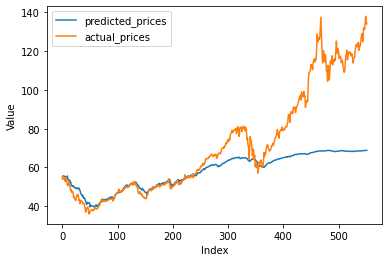

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(df)

# Create training and test datasets
train_data = scaled_prices[:int(len(df) * 0.8)]
test_data = scaled_prices[int(len(df) * 0.8) - 60:]

# Prepare the data for LSTM
def prepare_data(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size - 1):
        X.append(data[i:(i + window_size), 0])
        y.append(data[i + window_size, 0])
    return np.array(X), np.array(y)

window_size = 60
X_train, y_train = prepare_data(train_data, window_size)
X_test, y_test = prepare_data(test_data, window_size)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Make predictions
predictions = model.predict(X_test)
# predictions = scaler.inverse_transform(predictions)

# Execute the trading strategy
initial_cash = 10000
cash = initial_cash
num_shares = 0
buy_sell = []

for i in range(1, len(predictions)):
    if predictions[i] > prices[len(train_data) - 1 + i]:
        if cash >= prices[len(train_data) - 1 + i][0]:
            num_shares += 1
            cash -= prices[len(train_data) - 1 + i][0]
            buy_sell.append('buy')
        else:
            buy_sell.append('hold')
    else:
        if num_shares > 0:
            cash += prices[len(train_data) - 1 + i][0] * num_shares
            num_shares = 0
            buy_sell.append('sell')
        else:
            buy_sell.append('hold')

final_portfolio_value = cash + num_shares * prices[-1][0]

print(f"Initial cash: {initial_cash}")
print(f"Final portfolio value: {final_portfolio_value}")

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(data.index[-len(predictions):], prices[-len(predictions):], label='Actual Prices')
plt.plot(data.index[-len(predictions):], predictions, label='Predicted Prices')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()



Epoch 1/100
83/83 [==============================] - 9s 60ms/step - loss: 0.0018
Epoch 2/100
83/83 [==============================] - 5s 61ms/step - loss: 3.6140e-05
Epoch 3/100
83/83 [==============================] - 5s 61ms/step - loss: 3.5893e-05
Epoch 4/100
83/83 [==============================] - 5s 59ms/step - loss: 3.7326e-05
Epoch 5/100
83/83 [==============================] - 5s 60ms/step - loss: 3.6631e-05
Epoch 6/100
83/83 [==============================] - 5s 59ms/step - loss: 3.5088e-05
Epoch 7/100
83/83 [==============================] - 5s 60ms/step - loss: 3.3893e-05
Epoch 8/100
83/83 [==============================] - 5s 60ms/step - loss: 3.7395e-05
Epoch 9/100
83/83 [==============================] - 5s 57ms/step - loss: 3.5310e-05
Epoch 10/100
83/83 [==============================] - 4s 52ms/step - loss: 3.2942e-05
Epoch 11/100
83/83 [==============================] - 4s 52ms/step - loss: 3.4665e-05
Epoch 12/100
83/83 [==============================] - 4s 52ms/step 

ValueError: non-broadcastable output operand with shape (675,1) doesn't match the broadcast shape (675,101)

In [93]:

predictions = model.predict(X_test)
# predictions = scaler.inverse_transform(predictions)

# Execute the trading strategy
initial_cash = 10000
cash = initial_cash
num_shares = 0
buy_sell = []

for i in range(1, len(predictions)):
    if predictions[i] > prices[len(train_data) - 1 + i]:
        if cash >= prices[len(train_data) - 1 + i][0]:
            num_shares += 1
            cash -= prices[len(train_data) - 1 + i][0]
            buy_sell.append('buy')
        else:
            buy_sell.append('hold')
    else:
        if num_shares > 0:
            cash += prices[len(train_data) - 1 + i][0] * num_shares
            num_shares = 0
            buy_sell.append('sell')
        else:
            buy_sell.append('hold')

final_portfolio_value = cash + num_shares * prices[-1][0]

print(f"Initial cash: {initial_cash}")
print(f"Final portfolio value: {final_portfolio_value}")

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(data.index[-len(predictions):], prices[-len(predictions):], label='Actual Prices')
plt.plot(data.index[-len(predictions):], predictions, label='Predicted Prices')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()



22/22 [==============================] - 1s 25ms/step


NameError: name 'prices' is not defined

In [140]:
# 6. Show stats about the strategy
returns = np.diff(actual_prices)
strategy_returns = np.diff(actual_prices[buy_signals + sell_signals])

# Calculate performance metrics
cumulative_returns = np.cumsum(returns)
cumulative_strategy_returns = np.cumsum(strategy_returns)
annualized_returns = (cumulative_returns[-1] / len(returns)) * 252
annualized_strategy_returns = (cumulative_strategy_returns[-1] / len(strategy_returns)) * 252

# Calculate Sharpe ratio
returns_std = np.std(returns)
strategy_returns_std = np.std(strategy_returns)
sharpe_ratio = annualized_returns / returns_std
strategy_sharpe_ratio = annualized_strategy_returns / strategy_returns_std

print("Cumulative Returns: {:.2f}".format(cumulative_returns[-1]))
print("Cumulative Strategy Returns: {:.2f}".format(cumulative_strategy_returns[-1]))
print("Annualized Returns: {:.2f}".format(annualized_returns))
print("Annualized Strategy Returns: {:.2f}".format(annualized_strategy_returns))
print("Sharpe Ratio: {:.2f}".format(sharpe_ratio))
print("Strategy Sharpe Ratio: {:.2f}".format(strategy_sharpe_ratio))


Cumulative Returns: 80.12
Cumulative Strategy Returns: 12.05
Annualized Returns: 36.64
Annualized Strategy Returns: 86.76
Sharpe Ratio: 18.77
Strategy Sharpe Ratio: 17.75


Epoch 1/100
109/109 [==============================] - 9s 50ms/step - loss: 0.0023
Epoch 2/100
109/109 [==============================] - 6s 52ms/step - loss: 5.7287e-05
Epoch 3/100
109/109 [==============================] - 5s 50ms/step - loss: 5.4439e-05
Epoch 4/100
109/109 [==============================] - 5s 50ms/step - loss: 5.3198e-05
Epoch 5/100
109/109 [==============================] - 6s 51ms/step - loss: 5.5117e-05
Epoch 6/100
109/109 [==============================] - 6s 51ms/step - loss: 5.2380e-05
Epoch 7/100
109/109 [==============================] - 6s 51ms/step - loss: 5.4317e-05
Epoch 8/100
109/109 [==============================] - 5s 46ms/step - loss: 5.5352e-05
Epoch 9/100
109/109 [==============================] - 5s 45ms/step - loss: 4.8491e-05
Epoch 10/100
109/109 [==============================] - 5s 46ms/step - loss: 5.0330e-05
Epoch 11/100
109/109 [==============================] - 5s 46ms/step - loss: 5.5002e-05
Epoch 12/100
109/109 [=======================

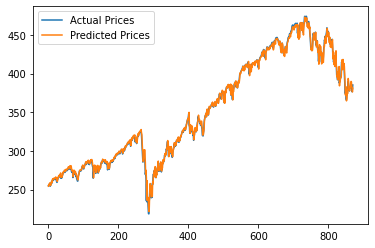

In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Load and preprocess the stock data
data = pd.read_csv("C:/Users/denni/Comp Sci/VS Code Projects/algos/_data/SPY_5min.txt")
data = data.infer_objects()
data.columns = ['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume']
data['DateTime'] = pd.to_datetime(data['DateTime'])
data = data.set_index("DateTime").resample('D').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'}).reset_index().dropna()
prices = data['Close'].values.reshape(-1, 1)

scaler = MinMaxScaler()
prices = scaler.fit_transform(prices)

# Prepare the data for the LSTM model

def partition(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

window_size = 60
X, y = partition(prices, window_size)

train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# # Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=32)

y_pred = model.predict(X_test)

y_test = scaler.inverse_transform(y_test)
y_pred = scaler.inverse_transform(y_pred)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Plot the actual prices and the predicted prices
plt.plot(y_test, label="Actual Prices")
plt.plot(y_pred, label="Predicted Prices")
plt.legend()
plt.show()


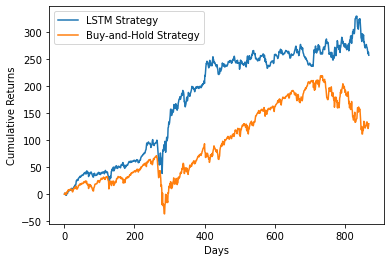

In [167]:
y_test = y_test.flatten()
y_pred = y_pred.flatten()

signals = np.where(y_pred > y_test, 1, -1) 

lstm_returns = signals[:-1] * (y_test[1:] - y_test[:-1])  
buy_and_hold_returns = y_test[1:] - y_test[:-1]  

lstm_cumulative_returns = np.cumsum(lstm_returns)
buy_and_hold_cumulative_returns = np.cumsum(buy_and_hold_returns)

plt.plot(lstm_cumulative_returns, label="LSTM Strategy")
plt.plot(buy_and_hold_cumulative_returns, label="Buy-and-Hold Strategy")
plt.xlabel("Days")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.show()


In [168]:
import numpy as np

def sharpe_ratio(returns, risk_free_rate=0.0, trading_days=252):
    excess_returns = returns - risk_free_rate
    annualized_return = np.mean(excess_returns) * trading_days
    annualized_volatility = np.std(excess_returns) * np.sqrt(trading_days)
    return annualized_return / annualized_volatility

# Calculate Sharpe Ratios
lstm_sharpe_ratio = sharpe_ratio(lstm_returns)
buy_and_hold_sharpe_ratio = sharpe_ratio(buy_and_hold_returns)

# Calculate annualized returns and volatilities
lstm_annualized_return = np.mean(lstm_returns) * 252
lstm_annualized_volatility = np.std(lstm_returns) * np.sqrt(252)
buy_and_hold_annualized_return = np.mean(buy_and_hold_returns) * 252
buy_and_hold_annualized_volatility = np.std(buy_and_hold_returns) * np.sqrt(252)

print("LSTM Strategy:")
print(f"Sharpe Ratio: {lstm_sharpe_ratio}")
print(f"Annualized Return: {lstm_annualized_return}")
print(f"Annualized Volatility: {lstm_annualized_volatility}")

print("\nBuy-and-Hold Strategy:")
print(f"Sharpe Ratio: {buy_and_hold_sharpe_ratio}")
print(f"Annualized Return: {buy_and_hold_annualized_return}")
print(f"Annualized Volatility: {buy_and_hold_annualized_volatility}")


LSTM Strategy:
Sharpe Ratio: 1.0544738161079705
Annualized Return: 74.32708137931017
Annualized Volatility: 70.4873655883169

Buy-and-Hold Strategy:
Sharpe Ratio: 0.5333237638444049
Annualized Return: 37.654187586206895
Annualized Volatility: 70.60286853670438


In [171]:
!pip install pandas_ta



[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


28/28 [==============================] - 0s 4ms/step
LSTM Strategy:
Sharpe Ratio: 0.03676856776475962
Annualized Return: 0.008011912698826893
Annualized Volatility: 0.21790113637512454

Buy-and-Hold Strategy:
Sharpe Ratio: 0.6977981351671506
Annualized Return: 0.15190472777808248
Annualized Volatility: 0.21769150721747804


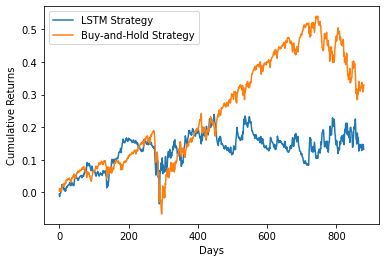

In [179]:
import numpy as np
import pandas as pd
import pandas_ta as pta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Read stock data and calculate technical indicators
data = pd.read_csv(f"C:/Users/denni/Comp Sci/VS Code Projects/algos/_data/SPY_5min.txt")
data = data.infer_objects()
data.columns = ['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume']
data['DateTime'] = pd.to_datetime(data['DateTime'])
data = data.set_index("DateTime").resample('D').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'}).reset_index().dropna()

# data['MA'] = pta.sma(data['Close'], length=20)
# data['MACD'] = pta.macd(data['Close'], fast=12, slow=26)['MACD_12_26_9']
# data['ATR'] = pta.atr(data['High'], data['Low'], data['Close'], length=14)

# Drop rows with NaN values (due to technical indicators requiring a certain number of data points)
data.dropna(inplace=True)

# Prepare the dataset for LSTM
look_back = 10
features = ['Close']
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data[features])

X, y = [], []
for i in range(look_back, len(data_scaled)):
    X.append(data_scaled[i - look_back:i, :])
    y.append(data_scaled[i, 0])

X, y = np.array(X), np.array(y)

# Split the dataset into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build and train the LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(look_back, len(features))))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

# Make predictions
y_pred = model.predict(X_test)
y_pred_inverse = scaler.inverse_transform(np.hstack((y_pred, np.zeros((y_pred.shape[0], len(features)-1)))))[:, 0]

# Create the trading strategy
actual_prices = data['Close'].values[train_size + look_back:]
buy_and_hold_returns = np.diff(actual_prices) / actual_prices[:-1]
lstm_returns = np.where(y_pred_inverse[1:] > actual_prices[:-1], buy_and_hold_returns, -buy_and_hold_returns)

# Calculate performance metrics as before
lstm_sharpe_ratio = sharpe_ratio(lstm_returns)
buy_and_hold_sharpe_ratio = sharpe_ratio(buy_and_hold_returns)
lstm_annualized_return = np.mean(lstm_returns) * 252
lstm_annualized_volatility = np.std(lstm_returns) * np.sqrt(252)
buy_and_hold_annualized_return = np.mean(buy_and_hold_returns) * 252
buy_and_hold_annualized_volatility = np.std(buy_and_hold_returns) * np.sqrt(252)

print("LSTM Strategy:")
print(f"Sharpe Ratio: {lstm_sharpe_ratio}")
print(f"Annualized Return: {lstm_annualized_return}")
print(f"Annualized Volatility: {lstm_annualized_volatility}")

print("\nBuy-and-Hold Strategy:")
print(f"Sharpe Ratio: {buy_and_hold_sharpe_ratio}")
print(f"Annualized Return: {buy_and_hold_annualized_return}")
print(f"Annualized Volatility: {buy_and_hold_annualized_volatility}")

# Ensure y_test and y_pred have the same dimensions
y_test = y_test.flatten()
y_pred = y_pred.flatten()

# Calculate buy/sell signals
signals = np.where(y_pred > y_test, 1, -1)  # 1 for buy, -1 for short

# Calculate daily returns for the LSTM strategy and the buy-and-hold strategy
lstm_returns = signals[:-1] * (y_test[1:] - y_test[:-1])  # Returns from the LSTM strategy
buy_and_hold_returns = y_test[1:] - y_test[:-1]  # Returns from the buy-and-hold strategy

# Calculate cumulative returns
lstm_cumulative_returns = np.cumsum(lstm_returns)
buy_and_hold_cumulative_returns = np.cumsum(buy_and_hold_returns)

# Plot the cumulative returns
plt.plot(lstm_cumulative_returns, label="LSTM Strategy")
plt.plot(buy_and_hold_cumulative_returns, label="Buy-and-Hold Strategy")
plt.xlabel("Days")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.show()